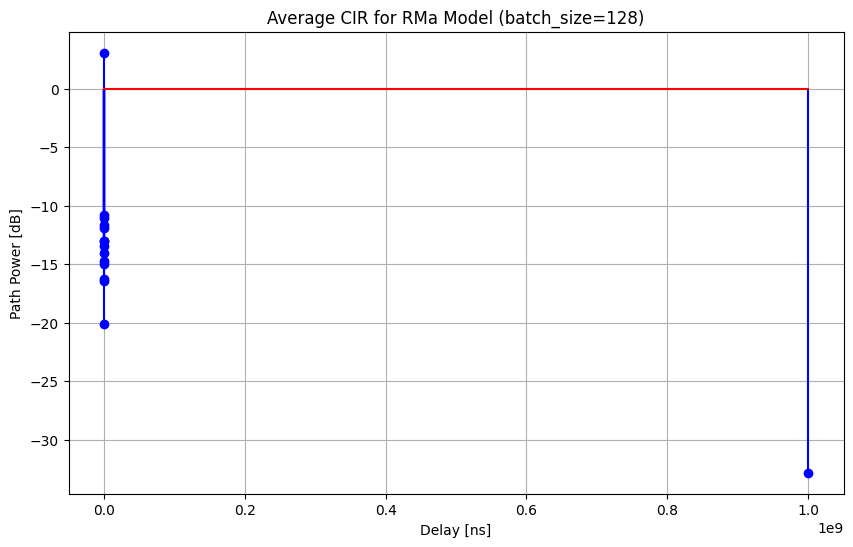

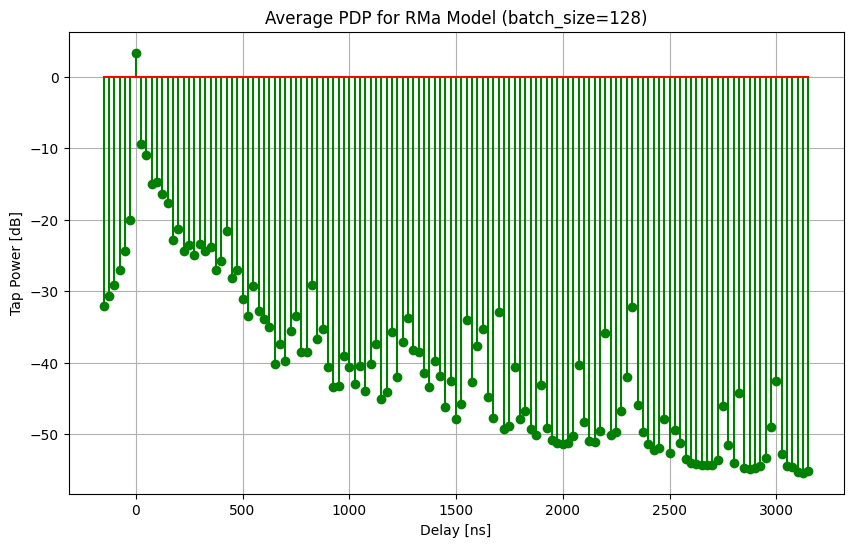

Channel coefficient shape is: (128, 1, 32, 1, 1, 15, 28)
Path delays shape is: (128, 1, 1, 15)
Discrete taps shape: (128, 1, 32, 1, 1, 28, 133)


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sionna.phy.channel.tr38901 import PanelArray, RMa
from sionna.phy.channel import cir_to_time_channel, time_lag_discrete_time_channel

# Set random seed for reproducibility
#tf.random.set_seed(42)

# Step 1: Define antenna arrays for BS and UT
bs_array = PanelArray(
    num_rows_per_panel=4,
    num_cols_per_panel=4,
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=3.5e9  # 3.5 GHz
)

ut_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=3.5e9
)

# Step 2: Instantiate RMa channel model
channel_model = RMa(
    carrier_frequency=3.5e9,
    ut_array=ut_array,
    bs_array=bs_array,
    direction='uplink',
    enable_pathloss=False,
    enable_shadow_fading=False,
    average_street_width=20.0,  # [m]
    average_building_height=5.0,  # [m]
    always_generate_lsp=False
)

# Step 3: Set up network topology for batch_size=128
batch_size = 128
num_ut = 1
num_bs = 1

# UT and BS locations (3D coordinates in meters)
# Repeat same position for all batches (or vary for different UT positions)
ut_loc = np.tile([[[100.0, 0.0, 1.5]]], [batch_size, 1, 1]).astype(np.float32)
bs_loc = np.tile([[[0.0, 0.0, 30.0]]], [batch_size, 1, 1]).astype(np.float32)

# Orientations (yaw, pitch, roll in radians)
ut_orientations = np.tile([[[0.0, 0.0, 0.0]]], [batch_size, 1, 1]).astype(np.float32)
bs_orientations = np.tile([[[0.0, 0.0, 0.0]]], [batch_size, 1, 1]).astype(np.float32)

# UT velocities (m/s)
ut_velocities = np.tile([[[10.0, -20.0, 0.0]]], [batch_size, 1, 1]).astype(np.float32)

# Indoor/outdoor state (False = outdoor)
in_state = np.tile([[False]], [batch_size, 1]).astype(np.bool_)

# Set topology
channel_model.set_topology(
    ut_loc=ut_loc,
    bs_loc=bs_loc,
    ut_orientations=ut_orientations,
    bs_orientations=bs_orientations,
    ut_velocities=ut_velocities,
    in_state=in_state
)

# Step 4: Generate CIR
a, tau = channel_model(28, 40e6)  # num_time_steps=28, sampling_frequency=40 MHz

# Step 5: Plot CIR (|a|^2 vs tau)
# Assume num_paths is consistent (e.g., 15); use first batch's tau for simplicity
# Shape of a: [128, 1, 1, 1, 32, num_paths, 28]
# Average over batch_size (128), tx_ant (32), and time_steps (28)
power_cir = np.mean(np.abs(a[:, 0, 0, 0, :, :, :])**2, axis=(0, 1, 3))  # Shape: [num_paths]
power_cir_db = 10 * np.log10(power_cir + 1e-12)  # dB scale
delays_cir = tau[0, 0, 0, :]  # Shape: [num_paths], use first batch's delays

plt.figure(figsize=(10, 6))
plt.stem(delays_cir * 1e9, power_cir_db, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Delay [ns]')
plt.ylabel('Path Power [dB]')
plt.title('Average CIR for RMa Model (batch_size=128)')
plt.grid(True)
plt.show()

# Step 6: Convert CIR to discrete taps for PDP
bandwidth = 40e6  # Match sampling_frequency
maximum_delay_spread = 3e-6  # 3 us
l_min, l_max = time_lag_discrete_time_channel(bandwidth, maximum_delay_spread=maximum_delay_spread)
hm = cir_to_time_channel(bandwidth, a, tau, l_min, l_max, normalize=False)

# Step 7: Plot PDP (|hm|^2 vs discrete delays)
# Shape of hm: [128, 1, 1, 1, 32, 28, l_max - l_min + 1]
power_pdp = np.mean(np.abs(hm[:, 0, :, 0, :, :, :])**2, axis=(0, 1, 2, 3))  # Shape: [num_taps]
power_pdp_db = 10 * np.log10(power_pdp + 1e-12)
delays_pdp = np.arange(l_min, l_max + 1) / bandwidth  # Delays in seconds

plt.figure(figsize=(10, 6))
plt.stem(delays_pdp * 1e9, power_pdp_db, linefmt='g-', markerfmt='go', basefmt='r-')
plt.xlabel('Delay [ns]')
plt.ylabel('Tap Power [dB]')
plt.title('Average PDP for RMa Model (batch_size=128)')
plt.grid(True)
plt.show()

# Debug shapes
print("Channel coefficient shape is:", a.shape)
print("Path delays shape is:", tau.shape)
print("Discrete taps shape:", hm.shape)

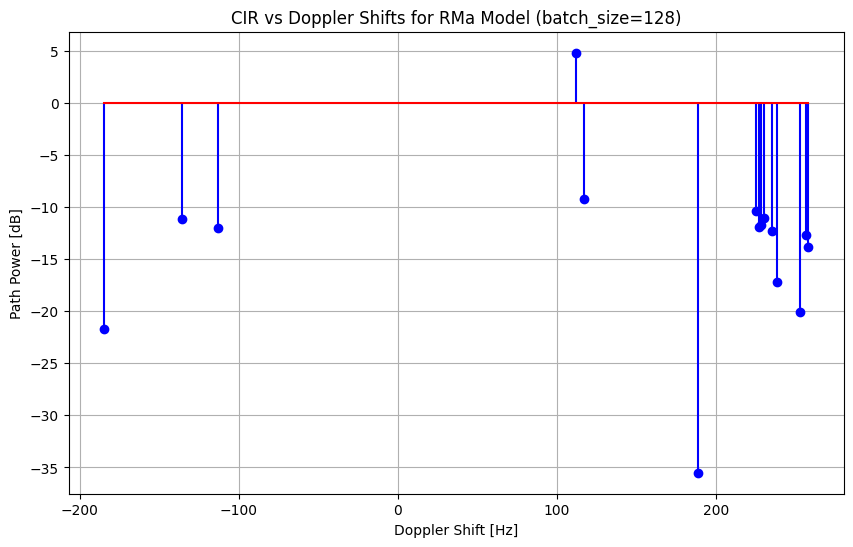

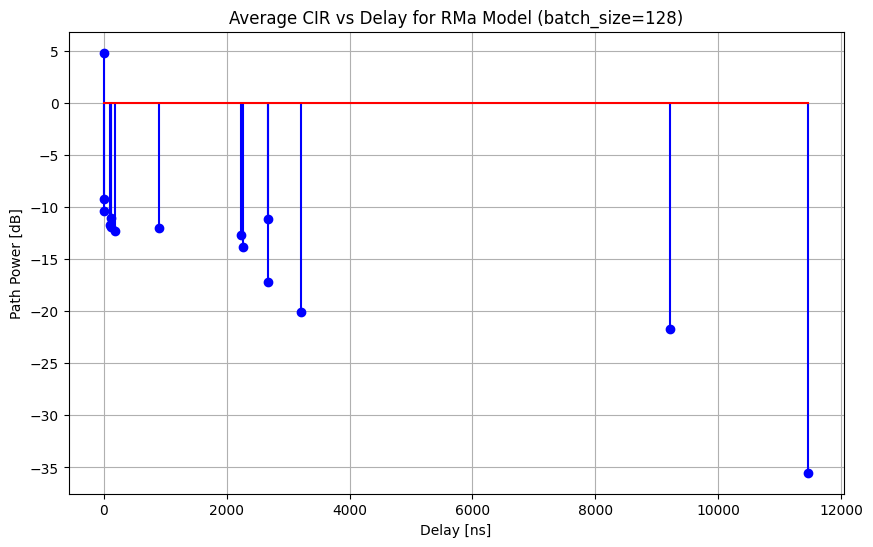

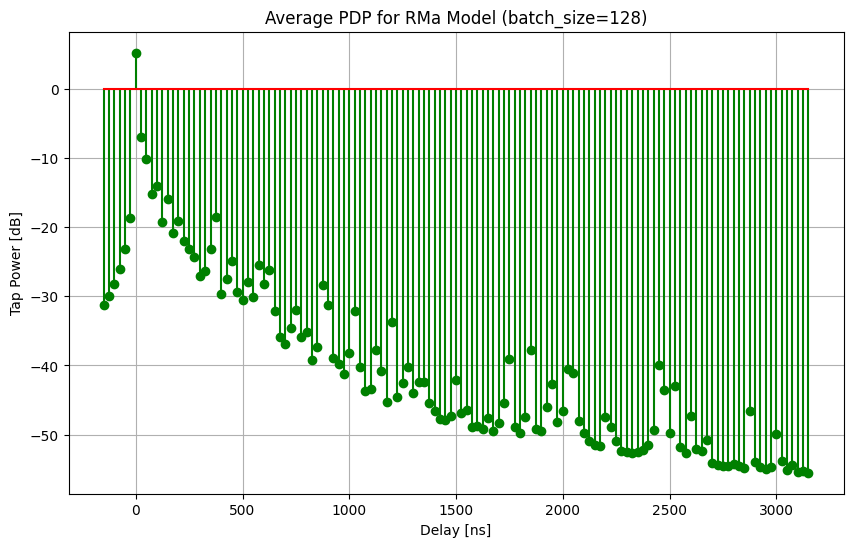

Channel coefficient shape is: (128, 1, 32, 1, 1, 15, 28)
Path delays shape is: (128, 1, 1, 15)
Discrete taps shape: (128, 1, 32, 1, 1, 28, 133)
Doppler shifts shape: (15,)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sionna.phy.channel.tr38901 import PanelArray, RMa
from sionna.phy.channel import cir_to_time_channel, time_lag_discrete_time_channel

# Set random seed for reproducibility
tf.random.set_seed(42)

# Step 1: Define antenna arrays for BS and UT
bs_array = PanelArray(
    num_rows_per_panel=4,
    num_cols_per_panel=4,
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=3.5e9  # 3.5 GHz
)

ut_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=3.5e9
)

# Step 2: Instantiate RMa channel model
channel_model = RMa(
    carrier_frequency=3.5e9,
    ut_array=ut_array,
    bs_array=bs_array,
    direction='uplink',
    enable_pathloss=False,
    enable_shadow_fading=True,
    average_street_width=20.0,  # [m]
    average_building_height=5.0,  # [m]
    always_generate_lsp=False
)

# Step 3: Set up network topology for batch_size=128
batch_size = 128
num_ut = 1
num_bs = 1

# UT and BS locations (3D coordinates in meters)
ut_loc = np.tile([[[100.0, 0.0, 1.5]]], [batch_size, 1, 1]).astype(np.float32)
bs_loc = np.tile([[[0.0, 0.0, 30.0]]], [batch_size, 1, 1]).astype(np.float32)

# Orientations (yaw, pitch, roll in radians)
ut_orientations = np.tile([[[0.0, 0.0, 0.0]]], [batch_size, 1, 1]).astype(np.float32)
bs_orientations = np.tile([[[0.0, 0.0, 0.0]]], [batch_size, 1, 1]).astype(np.float32)

# UT velocities (m/s) with Doppler
ut_velocities = np.tile([[[10.0, -20.0, 0.0]]], [batch_size, 1, 1]).astype(np.float32)

# Indoor/outdoor state (False = outdoor)
in_state = np.tile([[False]], [batch_size, 1]).astype(np.bool_)

# Set topology
channel_model.set_topology(
    ut_loc=ut_loc,
    bs_loc=bs_loc,
    ut_orientations=ut_orientations,
    bs_orientations=bs_orientations,
    ut_velocities=ut_velocities,
    in_state=in_state
)

# Step 4: Generate CIR
a, tau = channel_model(28, 40e6)  # num_time_steps=28, sampling_frequency=40 MHz

# Step 5: Compute Doppler shifts
# Shape of a: [128, 1, 1, 1, 32, num_paths, 28]
# Use phase difference between consecutive time steps to estimate Doppler
# Take first batch, first rx/tx, average over tx_ant
a_subset = a[0, 0, 0, 0, :, :, :]  # Shape: [32, num_paths, 28]
phase = np.angle(a_subset)  # Shape: [32, num_paths, 28]
delta_phase = np.diff(phase, axis=2)  # Phase difference: [32, num_paths, 27]
delta_t = 1 / 40e6  # Time step = 25 ns
doppler_shifts = np.mean(delta_phase / (2 * np.pi * delta_t), axis=(0, 2))  # Shape: [num_paths]

# Step 6: Plot CIR vs Doppler shifts
# Average |a|^2 over batch_size (128), tx_ant (32), time_steps (28)
power_cir = np.mean(np.abs(a[:, 0, 0, 0, :, :, :])**2, axis=(0, 1, 3))  # Shape: [num_paths]
power_cir_db = 10 * np.log10(power_cir + 1e-12)  # dB scale

plt.figure(figsize=(10, 6))
plt.stem(doppler_shifts, power_cir_db, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Doppler Shift [Hz]')
plt.ylabel('Path Power [dB]')
plt.title('CIR vs Doppler Shifts for RMa Model (batch_size=128)')
plt.grid(True)
plt.show()

# Step 7: Plot CIR vs Delay (for reference)
delays_cir = tau[0, 0, 0, :]  # Shape: [num_paths], first batch
plt.figure(figsize=(10, 6))
plt.stem(delays_cir * 1e9, power_cir_db, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Delay [ns]')
plt.ylabel('Path Power [dB]')
plt.title('Average CIR vs Delay for RMa Model (batch_size=128)')
plt.grid(True)
plt.show()

# Step 8: Plot PDP (for completeness)
bandwidth = 40e6
maximum_delay_spread = 3e-6
l_min, l_max = time_lag_discrete_time_channel(bandwidth, maximum_delay_spread=maximum_delay_spread)
hm = cir_to_time_channel(bandwidth, a, tau, l_min, l_max, normalize=False)
power_pdp = np.mean(np.abs(hm[:, 0, :, 0, :, :, :])**2, axis=(0, 1, 2, 3))  # Shape: [num_taps]
power_pdp_db = 10 * np.log10(power_pdp + 1e-12)
delays_pdp = np.arange(l_min, l_max + 1) / bandwidth

plt.figure(figsize=(10, 6))
plt.stem(delays_pdp * 1e9, power_pdp_db, linefmt='g-', markerfmt='go', basefmt='r-')
plt.xlabel('Delay [ns]')
plt.ylabel('Tap Power [dB]')
plt.title('Average PDP for RMa Model (batch_size=128)')
plt.grid(True)
plt.show()

# Debug shapes
print("Channel coefficient shape is:", a.shape)
print("Path delays shape is:", tau.shape)
print("Discrete taps shape:", hm.shape)
print("Doppler shifts shape:", doppler_shifts.shape)